In [1]:
from logging import getLogger
from logging.config import dictConfig

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torcheval.metrics import BinaryAUPRC, BinaryAUROC, BinaryPrecisionRecallCurve
from yaml import safe_load

from streamvigil import ARCUS, CSVDataset
from streamvigil.detectors import RAPP

In [2]:
# Logger
with open("../logging.yml", encoding="utf-8") as file:
    config = safe_load(file)
dictConfig(config)
logger = getLogger(__name__)

In [3]:
random_state = 42

# Dataset
data = CSVDataset(
    "../../data/INSECTS/INSECTS_Abr.csv.gz",
    train=True,
    test_size=0.0,
    random_state=random_state,
)

# DataLoader
loader = DataLoader(
    data,
    batch_size=128,
)

In [4]:
detector = RAPP(
    encoder_dims=[33, 28, 23, 18],
    decoder_dims=[18, 23, 28, 33],
    batch_norm=True,
)

arcus = ARCUS(detector, max_epochs=5)

In [5]:
# Initialize model pool
logger.info("Start initializing model pool...")
X, _ = next(iter(loader))
arcus.init(X)
logger.info("Completed initializing model pool!")

2024-06-05 16:32:03,313 [INFO] __main__: Start initializing model pool...
2024-06-05 16:32:04,069 [INFO] streamvigil._arcus: loss: 0.222946
2024-06-05 16:32:04,090 [INFO] __main__: Completed initializing model pool!


In [6]:
# ARCUS simulation
auroc = BinaryAUROC()
auprc = BinaryAUPRC()
pr_curve = BinaryPrecisionRecallCurve()

logger.info("Start ARCUS simulation...")
for X, y in loader:
    scores = arcus.run(X)
    auroc.update(scores, y)
    auprc.update(scores, y)
    pr_curve.update(scores, y)

# Compute AUROC score
logger.info(f"AUROC Score: {auroc.compute()}")
logger.info(f"AUPRC Score: {auprc.compute()}")

logger.info("Completed ARCUS simulation!")

2024-06-05 16:32:04,094 [INFO] __main__: Start ARCUS simulation...
2024-06-05 16:32:04,107 [INFO] streamvigil._arcus: Start training model with id d40c56d6-df56-4d30-8823-d9c3219339eb...
2024-06-05 16:32:04,115 [INFO] streamvigil._arcus: loss: 0.212500
2024-06-05 16:32:04,140 [INFO] streamvigil._arcus: Completed training model with id d40c56d6-df56-4d30-8823-d9c3219339eb!
2024-06-05 16:32:04,145 [INFO] streamvigil._arcus: Start training model with id d40c56d6-df56-4d30-8823-d9c3219339eb...
2024-06-05 16:32:04,152 [INFO] streamvigil._arcus: loss: 0.199701
2024-06-05 16:32:04,178 [INFO] streamvigil._arcus: Completed training model with id d40c56d6-df56-4d30-8823-d9c3219339eb!
2024-06-05 16:32:04,184 [INFO] streamvigil._arcus: Start training model with id d40c56d6-df56-4d30-8823-d9c3219339eb...
2024-06-05 16:32:04,190 [INFO] streamvigil._arcus: loss: 0.197163
2024-06-05 16:32:04,213 [INFO] streamvigil._arcus: Completed training model with id d40c56d6-df56-4d30-8823-d9c3219339eb!
2024-06-0

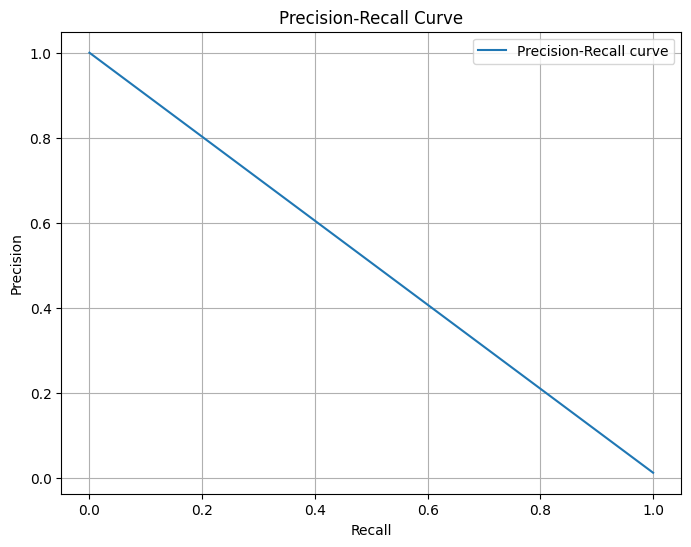

In [7]:
# Visualize Precision-Recall Curve
precision, recall, thresholds = pr_curve.compute()

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()